In [1]:
from autoencoder.autoencoder import AutoEncoder
import torch
import pickle
from autoencoder.loss import Loss
from sindy_network import SINDy
from sindy.SINDy_library import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
device = 'cuda'
import numpy as np
  

In [2]:
params = pickle.load(open('utils/model1_params.pkl', 'rb'))

encoder = AutoEncoder(params, 'encoder')
decoder = AutoEncoder(params, 'decoder')
sindy = SINDy(encoder, decoder, params)
sindy.load_state_dict(torch.load('model_lorenz_1'))
sindy.to(device)
training_data = pickle.load(open('dataset_generation/test_data.pkl', 'rb'))

criterion = Loss(
        params['loss_weight_decoder'],
        params['loss_weight_sindy_z'],
        params['loss_weight_sindy_x'],
        params['loss_weight_sindy_regularization']
        )
    
def run():
    x, dx, dz, dz_pred, x_decode, dx_decode, sindy_coefficients, sindy_predict, ddz, ddx, ddx_decode, z = sindy(torch.from_numpy(training_data['x']).to(device=device), torch.from_numpy(training_data['dx']).to(device=device), torch.from_numpy(training_data['ddx']).to(device=device))
    loss = criterion(x, dx, dz, dz_pred, x_decode, dx_decode, sindy_coefficients, ddz, ddx, ddx_decode, sindy.coefficient_mask)
     
    return x, dx, dz, dz_pred, x_decode, dx_decode, sindy_coefficients, sindy_predict, ddz, ddx, ddx_decode, z, loss  

In [3]:
x, dx, dz, dz_pred, x_decode, dx_decode, sindy_coefficients, sindy_predict, ddz, ddx, ddx_decode, z, loss = run()

In [4]:
sindy_coefficients = sindy_coefficients.to('cpu')
z = z.to('cpu').detach()#.numpy()
a1 = 1
a2 = training_data['sindy_coefficients'][2,0]/sindy_coefficients[2,0]
a3 = np.sqrt(sindy_coefficients[5,2]/sindy_coefficients[6,1]*a2**2)
b3 = -sindy_coefficients[0,2]/sindy_coefficients[3,2]

sindy_coefficients_transformed = np.zeros(sindy_coefficients.shape)
sindy_coefficients_transformed[1,0] = sindy_coefficients[1,0]
sindy_coefficients_transformed[2,0] = sindy_coefficients[2,0]*a2/a1
sindy_coefficients_transformed[1,1] = sindy_coefficients[6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = sindy_coefficients[2,1]
sindy_coefficients_transformed[6,1] = sindy_coefficients[6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = sindy_coefficients[3,2]
sindy_coefficients_transformed[5,2] = sindy_coefficients[5,2]*a1*a2/a3

z0_transformed = np.array([z[0,0]/a1,
                           z[0,1]/a2,
                           (z[0,2] - b3)/a3])

print(sindy_coefficients)

tensor([[ 2.4887,  0.3623, -0.1841],
        [ 1.1577, -1.3692, -0.2851],
        [-0.7681, -0.5091, -0.1910],
        [-1.6807, -0.0603,  1.2478],
        [ 2.2366,  0.1543, -1.3914],
        [ 2.5714, -0.6884,  0.0727],
        [ 0.0933,  2.1423,  0.6087],
        [ 1.0940, -0.0683,  0.2106],
        [-0.1972, -0.0265, -1.3351],
        [-0.1860, -1.9102,  1.0664],
        [-0.9676, -0.2410, -1.0163],
        [-0.0717, -0.1406,  1.4028],
        [ 1.3215, -1.3983,  0.7466],
        [-1.6211,  0.0592, -0.1529],
        [ 0.5700, -1.0708, -3.1644],
        [-1.0961, -0.0693,  0.2938],
        [-0.7849,  0.1058, -1.0981],
        [ 0.7518, -0.5878, -0.2252],
        [-0.3376,  1.1982,  0.1201],
        [ 0.4191,  0.1132, -0.0095]], dtype=torch.float64)


In [5]:
t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])

lorenz_sim = sindy_simulate(training_data['z'][0, 0], t, training_data['sindy_coefficients'],
                            params['poly_order'], params['include_sine'])
z_sim = sindy_simulate(z[0].numpy(), t, params['coefficient_mask']*sindy_coefficients.numpy(),
                       params['poly_order'], params['include_sine'])
z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed,
                                   params['poly_order'], params['include_sine'])

c:\Users\Kiki\Documents\GitHub\DL24-Group64\sindy\SINDy_library.py:155: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  x = odeint(f, x0, t)


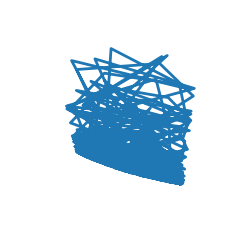

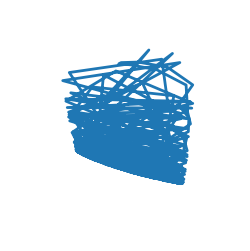

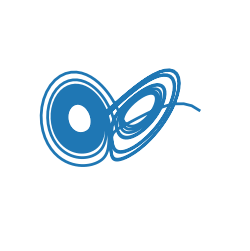

In [6]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(z_sim_transformed[:,0], z_sim_transformed[:,1], z_sim_transformed[:,2], linewidth=2)
plt.axis('off')
ax2.view_init(azim=120)

fig3 = plt.figure(figsize=(3,3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=2)
plt.xticks([])
plt.axis('off')
ax3.view_init(azim=120)

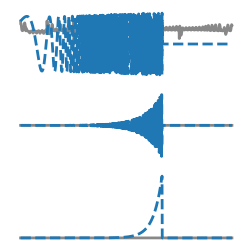

In [7]:
plt.figure(figsize=(3,3))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, z[:2000,i], color='#888888', linewidth=2)
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

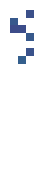

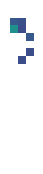

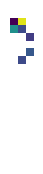

In [8]:
Xi_plot = (params['coefficient_mask']*sindy_coefficients.numpy())
Xi_plot[Xi_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
Xi_transformed_plot[Xi_transformed_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_transformed_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_true_plot = np.copy(training_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])